In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import string

Read in test and training data

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Let's try to visualize the most common keywords

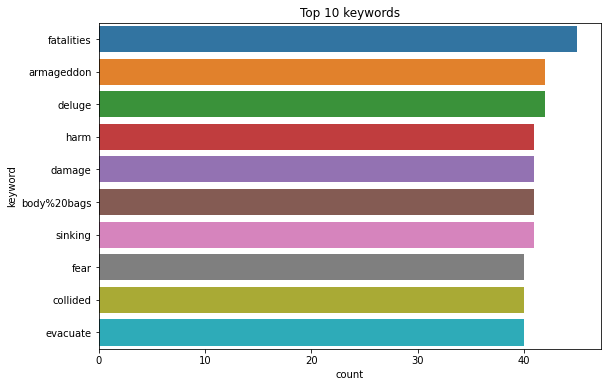

In [3]:
plt.figure(figsize=(9,6))
sns.countplot(y=train_df.keyword, order = train_df.keyword.value_counts().iloc[:10].index)
plt.title('Top 10 keywords')
plt.show()

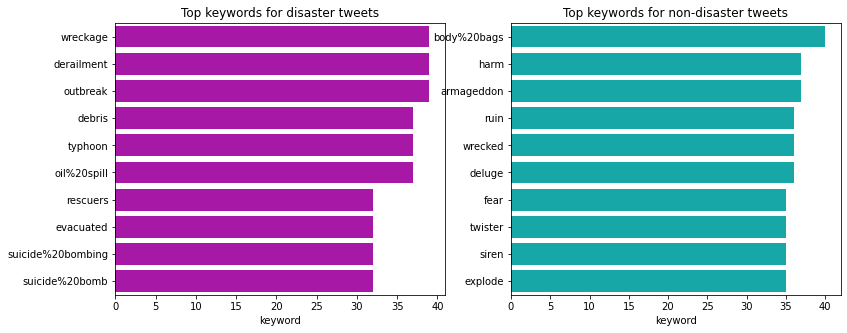

In [4]:
kw_d = train_df[train_df.target==1].keyword.value_counts().head(10)
kw_nd = train_df[train_df.target==0].keyword.value_counts().head(10)

plt.figure(figsize=(13,5))
plt.subplot(121)
sns.barplot(kw_d, kw_d.index, color='m')
plt.title('Top keywords for disaster tweets')
plt.subplot(122)
sns.barplot(kw_nd, kw_nd.index, color='c')
plt.title('Top keywords for non-disaster tweets')
plt.show()

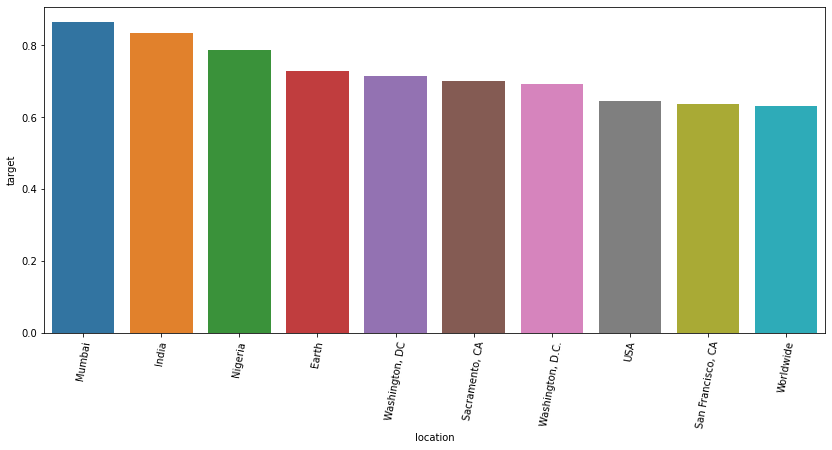

In [22]:
raw_loc = train_df.location.value_counts()
top_loc = list(raw_loc[raw_loc>=10].index)
top_only = train_df[train_df.location.isin(top_loc)]

top_l = top_only.groupby('location').mean()['target'].sort_values(ascending=False).iloc[:10]
plt.figure(figsize=(14,6))
sns.barplot(x=top_l.index, y=top_l)
plt.xticks(rotation=80)
plt.show()

In [5]:
import re

def text_process(text):
    text = re.sub(r'https?://\S+', '', text) # Remove links
    text = re.sub(r'\n',' ', text) # Remove line breaks
    text = re.sub('\s+', ' ', text).strip() # Remove extra spaces
    return text

test_str = train_df.loc[320, 'text']
print(test_str)
print(text_process(test_str))

Photo: Sketch I did based on the A Taste of Armageddon episode of #startrek #tos http://t.co/a2e6dcsk88
Photo: Sketch I did based on the A Taste of Armageddon episode of #startrek #tos


In [6]:
def get_hashtags(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"#\w+", tweet)]) or 'no'

def get_mentions(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"@\w+", tweet)]) or 'no'

def get_links(tweet):
    return " ".join([match.group(0)[:] for match in re.finditer(r"https?://\S+", tweet)]) or 'no'

def extract_features(df):
    df['text_clean'] = df['text'].apply(lambda x: text_process(x))
    df['hashtags'] = df['text'].apply(lambda x: get_hashtags(x))
    df['mentions'] = df['text'].apply(lambda x: get_mentions(x))
    df['links'] = df['text'].apply(lambda x: get_links(x))
    return df
    
train_df = extract_features(train_df)
test_df = extract_features(test_df)
train_df.head(5)

,id,keyword,location,text,target,text_clean,hashtags,mentions,links
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...,earthquake,no,no
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,no,no,no
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...,no,no,no
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or...",wildfires,no,no
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...,Alaska wildfires,no,no


Vectorize the tweets and metadata using CountVectorizer

In [7]:
import category_encoders as ce

# Target encoding
features = ['keyword', 'location']
encoder = ce.TargetEncoder(cols=features)
encoder.fit(train_df[features],train_df['target'])

train_df = train_df.join(encoder.transform(train_df[features]).add_suffix('_target'))
test_df = test_df.join(encoder.transform(test_df[features]).add_suffix('_target'))

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

vec_links = CountVectorizer(min_df = 5, analyzer = 'word', token_pattern = r'https?://\S+') # Only include those >=5 occurrences
link_vec = vec_links.fit_transform(train_df['links'])
link_vec_test = vec_links.transform(test_df['links'])
X_train_link = pd.DataFrame(link_vec.toarray(), columns=vec_links.get_feature_names())
X_test_link = pd.DataFrame(link_vec_test.toarray(), columns=vec_links.get_feature_names())

vec_men = CountVectorizer(min_df = 5)
men_vec = vec_men.fit_transform(train_df['mentions'])
men_vec_test = vec_men.transform(test_df['mentions'])
X_train_men = pd.DataFrame(men_vec.toarray(), columns=vec_men.get_feature_names())
X_test_men = pd.DataFrame(men_vec_test.toarray(), columns=vec_men.get_feature_names())

vec_hash = CountVectorizer(min_df = 5)
hash_vec = vec_hash.fit_transform(train_df['hashtags'])
hash_vec_test = vec_hash.transform(test_df['hashtags'])
X_train_hash = pd.DataFrame(hash_vec.toarray(), columns=vec_hash.get_feature_names())
X_test_hash = pd.DataFrame(hash_vec_test.toarray(), columns=vec_hash.get_feature_names())
print (X_train_link.shape, X_train_men.shape, X_train_hash.shape)

(7613, 6) (7613, 18) (7613, 107)


Extract tweet statistics

In [9]:
from wordcloud import STOPWORDS

def create_stat(df):
    # Tweet length
    df['text_len'] = df['text_clean'].apply(len)
    # Word count
    df['word_count'] = df["text_clean"].apply(lambda x: len(str(x).split()))
    # Stopword count
    df['stop_word_count'] = df['text_clean'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
    # Punctuation count
    df['punctuation_count'] = df['text_clean'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    # Count of hashtags (#)
    df['hashtag_count'] = df['hashtags'].apply(lambda x: len(str(x).split()))
    # Count of mentions (@)
    df['mention_count'] = df['mentions'].apply(lambda x: len(str(x).split()))
    # Count of links
    df['link_count'] = df['links'].apply(lambda x: len(str(x).split()))
    # Count of uppercase letters
    df['caps_count'] = df['text_clean'].apply(lambda x: sum(1 for c in str(x) if c.isupper()))
    # Ratio of uppercase letters
    df['caps_ratio'] = df['caps_count'] / df['text_len']
    return df

train_df = create_stat(train_df)
test_df = create_stat(test_df)

TF-IDF processing

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec_text = TfidfVectorizer(min_df = 10, ngram_range = (1,2), stop_words='english') # unigrams and bigrams
# Only include >= 10 occurrences
text_vec = vec_text.fit_transform(train_df['text_clean'])
text_vec_test = vec_text.transform(test_df['text_clean'])
X_train_text = pd.DataFrame(text_vec.toarray(), columns=vec_text.get_feature_names())
X_test_text = pd.DataFrame(text_vec_test.toarray(), columns=vec_text.get_feature_names())
print (X_train_text.shape)

train_df = train_df.join(X_train_link, rsuffix='_link')
train_df = train_df.join(X_train_men, rsuffix='_mention')
train_df = train_df.join(X_train_hash, rsuffix='_hashtag')
train_df = train_df.join(X_train_text, rsuffix='_text')
test_df = test_df.join(X_test_link, rsuffix='_link')
test_df = test_df.join(X_test_men, rsuffix='_mention')
test_df = test_df.join(X_test_hash, rsuffix='_hashtag')
test_df = test_df.join(X_test_text, rsuffix='_text')
print (train_df.shape, test_df.shape)

(7613, 1691)
(7613, 1842) (3263, 1841)


Apply Logistic Regression model to data

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import csv

features_to_drop = ['id', 'keyword','location','text','text_clean', 'hashtags', 'mentions','links']
scaler = MinMaxScaler()

X_train = train_df.drop(columns = features_to_drop + ['target'])
X_test = test_df.drop(columns = features_to_drop)
y_train = train_df.target

lr = LogisticRegression(solver='liblinear', random_state=777)

pipeline = Pipeline([('scale',scaler), ('lr', lr),])

pipeline.fit(X_train, y_train)
test_predictions = pipeline.predict(X_test)

with open('submission.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["id", "target"])
    for i in range(len(test_df.index)):
        writer.writerow([test_df["id"][i], test_predictions[i]])

print ('Training accuracy: %.4f' % pipeline.score(X_train, y_train))

Training accuracy: 0.8585


F1 score

In [13]:
from sklearn.metrics import classification_report
print(classification_report(y_train,pipeline.predict(X_train)))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      4342
           1       0.88      0.78      0.83      3271

    accuracy                           0.86      7613
   macro avg       0.86      0.85      0.85      7613
weighted avg       0.86      0.86      0.86      7613



In [16]:
# Cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=123)
cv_score = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1')

# Feature selection
from sklearn.feature_selection import RFECV

steps = 20
n_features = len(X_train.columns)
X_range = np.arange(n_features - (int(n_features/steps)) * steps, n_features+1, steps)

rfecv = RFECV(estimator=lr, step=steps, cv=cv, scoring='f1')

pipeline2 = Pipeline([('scale',scaler), ('rfecv', rfecv)])
pipeline2.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('rfecv',
                 RFECV(cv=ShuffleSplit(n_splits=5, random_state=123, test_size=0.2, train_size=None),
                       estimator=LogisticRegression(C=1.0, class_weight=None,
                                                    dual=False,
                                                    fit_intercept=True,
                                                    intercept_scaling=1,
                                                    l1_ratio=None, max_iter=100,
                                                    multi_class='warn',
                                                    n_jobs=None, penalty='l2',
                                                    random_state=777,
                                                    solver='liblinear',
                                                    tol=0.0001, verbose=0,
                                        

In [17]:
selected_features = X_train.columns[rfecv.ranking_ == 1]
X_train2 = X_train[selected_features]
X_test2 = X_test[selected_features]

pipeline.fit(X_train2, y_train)
cv2 = ShuffleSplit(n_splits=5, test_size=0.2, random_state=456)
cv_score2 = cross_val_score(pipeline, X_train2, y_train, cv=cv2, scoring='f1')
print('Cross validation F-1 score: %.3f' %np.mean(cv_score2))

Cross validation F-1 score: 0.786


In [18]:
from sklearn.model_selection import GridSearchCV

grid={"C":np.logspace(-2,2,5), "penalty":["l1","l2"]}
lr_cv = GridSearchCV(LogisticRegression(solver='liblinear', random_state=20), grid, cv=cv2, scoring = 'f1')

pipeline_grid = Pipeline([('scale',scaler), ('gridsearch', lr_cv),])

pipeline_grid.fit(X_train2, y_train)

print("Best parameter: ", lr_cv.best_params_)
print("F-1 score: %.3f" %lr_cv.best_score_)

Best parameter:  {'C': 10.0, 'penalty': 'l2'}
F-1 score: 0.789


In [19]:
y_test2 = pipeline_grid.predict(X_test2)
with open('submission.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["id", "target"])
    for i in range(len(test_df.index)):
        writer.writerow([test_df["id"][i], y_test2[i]])